# Regridding data

In [1]:
import cartopy.crs as ccrs
import libs.helpers as helpers
import matplotlib
import matplotlib.pyplot as plt
import xesmf
import xarray

import warnings
warnings.filterwarnings('ignore')


def regrid(
    data, 
    grid=xesmf.util.grid_global(1.875, 1.25), 
    method='bilinear', 
    extrap_method=None, 
    save_file=None
):
    regridder = xesmf.Regridder(data, grid, method=method, extrap_method=extrap_method)
    data_regridded = regridder(data)
    save_file != None and data_regridded.to_netcdf(save_file)

    return data_regridded


def regrid_latlon_nsidc(i, o, method='bilinear'):
    data = xarray.open_mfdataset(paths=i, combine='by_coords')
    data_regrid = regrid(data, method=method)

    mask = data_regrid.mask.where(data_regrid.mask > 5).where(data_regrid.mask < 16)
    data_regrid['mask'] = mask

    o_edited = o.replace('.nc', f'_{method}.nc')
    data_regrid.to_netcdf(o_edited)

    return o_edited


def plot_regridded_data(data, title='', x='lon', y='lat'):
    transform = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        1, 
        1,
        figsize=(10, 10),
        subplot_kw={ 
            'projection': ccrs.Stereographic(central_latitude=90.0)
        }
    )
    fig.suptitle(title)
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.set_extent([-180, 180, 50, 90], transform)
    gl = ax.gridlines()
    gl.ylocator = matplotlib.ticker.LinearLocator(4)
    data.plot.pcolormesh(
        ax=ax,
        x=x, 
        y=y,
        transform=transform
    )

## NSIDC regions to lat-lon

In [2]:
path = '_data/NSIDC_Regions_Masks.nc'
o = '_data/_cache/NSIDC_Regions_Masks_LatLon.nc'
nsidc_mask = xarray.open_mfdataset(paths='_data/NSIDC_Regions_Masks.nc', combine='by_coords')

o_bilinear = regrid_latlon_nsidc(path, o)
o_nearest_s2d = regrid_latlon_nsidc(path, o, method='nearest_s2d')

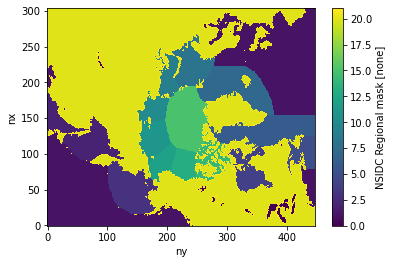

In [3]:
nsidc_mask.mask.plot()

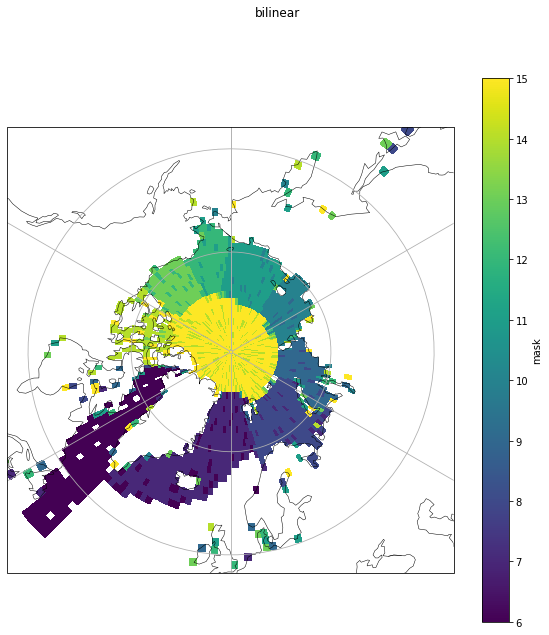

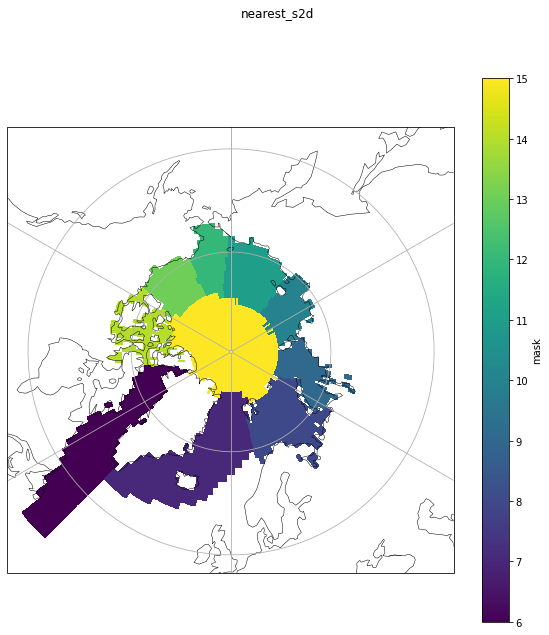

In [4]:
plot_regridded_data(xarray.open_mfdataset(paths=o_bilinear, combine='by_coords').mask, title='bilinear')
plot_regridded_data(xarray.open_mfdataset(paths=o_nearest_s2d, combine='by_coords').mask, title='nearest_s2d')

## Sea-ice concentration to lat-lon

In [5]:
siconc_base = helpers.get_data('ssp585', 'SImon', 'siconc', 'r2i1p1f2')
siconca_base = helpers.get_data('ssp585', 'SImon', 'siconca', 'r2i1p1f2')

siconc = siconc_base.siconc[0, :, :]
siconca = siconca_base.siconca[0, :, :]

siconc_latlon = regrid(siconc_base).siconc[0, :, :]
siconc_latlon_ext = regrid(siconc_base, extrap_method='nearest_s2d').siconc[0, :, :]
siconc_latlon_s2d = regrid(siconc_base, method='nearest_s2d').siconc[0, :, :]

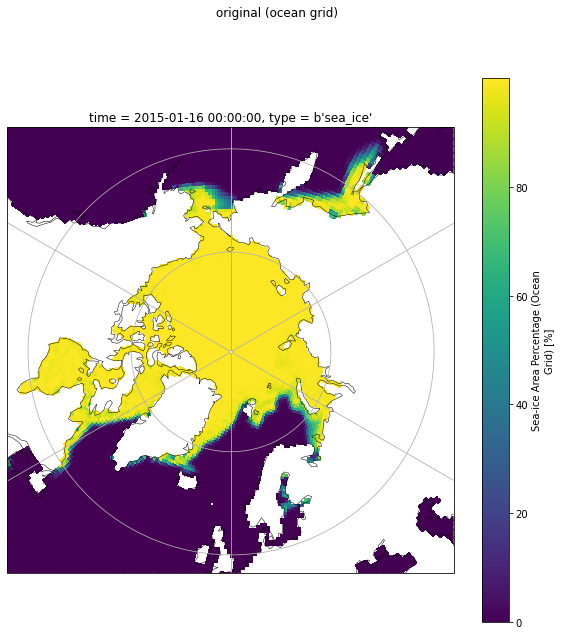

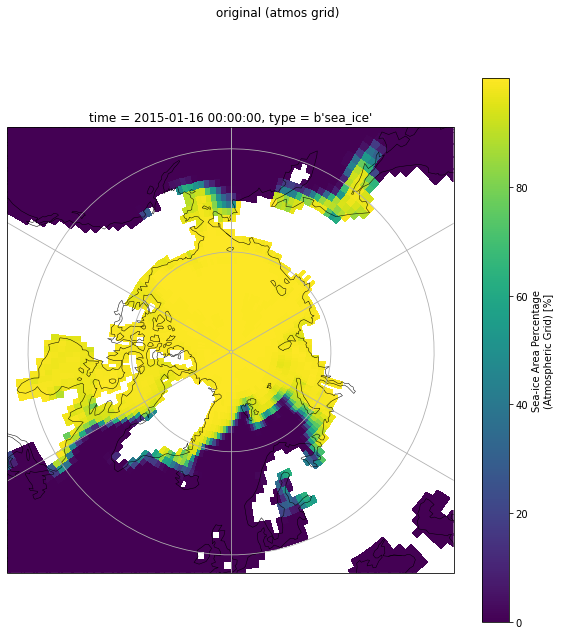

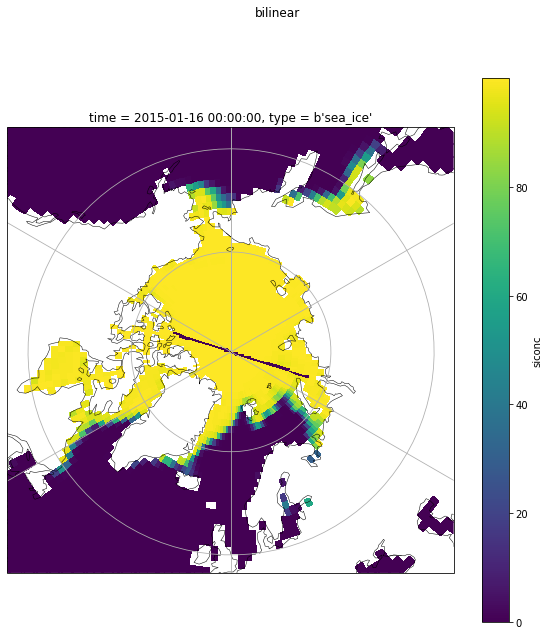

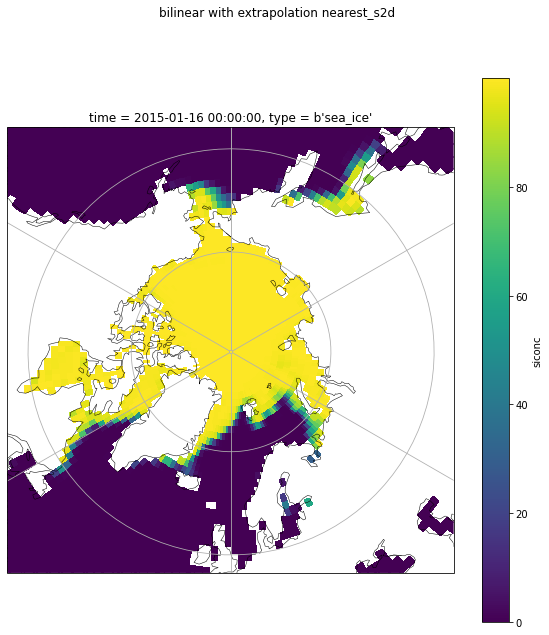

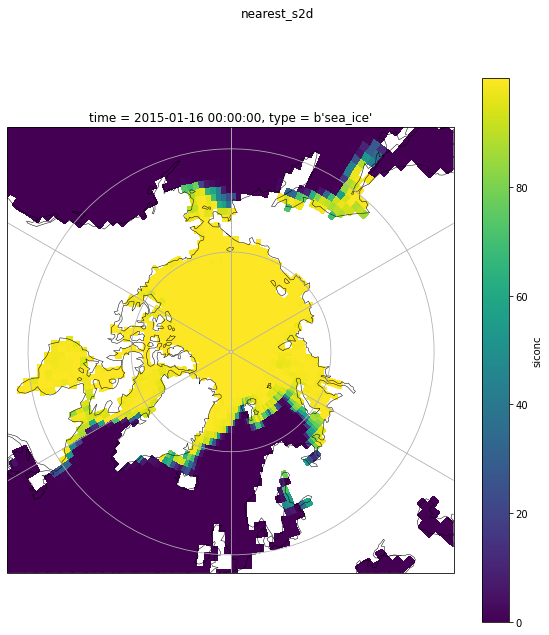

In [6]:
plot_regridded_data(siconc, title='original (ocean grid)', x='longitude', y='latitude')
plot_regridded_data(siconca, title='original (atmos grid)')
plot_regridded_data(siconc_latlon, title='bilinear')
plot_regridded_data(siconc_latlon_ext, title='bilinear with extrapolation nearest_s2d')
plot_regridded_data(siconc_latlon_s2d, title='nearest_s2d')

In [7]:
path_areacella = '_data/cmip6/UKESM1/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacella = xarray.open_mfdataset(paths=path_areacella, combine='by_coords').areacella

path_areacello = '_data/cmip6/UKESM1/areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacello = xarray.open_mfdataset(paths=path_areacello, combine='by_coords').areacello

siconc = siconc.where(siconc.latitude > 60)
siconca = siconca.where(siconca.lat > 60)
siconc_latlon = siconc_latlon.where(siconc_latlon.lat > 60)
siconc_latlon_ext = siconc_latlon_ext.where(siconc_latlon_ext.lat > 60)
siconc_latlon_s2d = siconc_latlon_s2d.where(siconc_latlon_s2d.lat > 60)

area_o = (siconc * areacello).sum(dim=('i', 'j'), skipna=True).values
area_a = (siconca * areacella).sum(dim=('lat', 'lon'), skipna=True).values
area_bil = (siconc_latlon.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.
area_ext = (siconc_latlon_ext.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.
area_s2d = (siconc_latlon_s2d.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.

In [8]:
print('siconc (ocean grid):')
print(f'-> area: {area_o}')

print('\nsiconca (atmosphere grid):')
print(f'-> area: {area_a}')
print(f'-> siconc diff: {round(100 * (area_a - area_o)/area_o, 4)}%')

print('\nbilinear:')
print(f'-> area: {area_bil}')
print(f'-> siconc diff: {round(100 * (area_bil - area_o)/area_o, 4)}%')

print('\nbilinear with extrapolation nearest_s2d:')
print(f'-> area: {area_ext}')
print(f'-> siconc diff: {round(100 * (area_ext - area_o)/area_o, 4)}%')

print('\ns2d:')
print(f'-> area: {area_s2d}')
print(f'-> siconc diff: {round(100 * (area_s2d - area_o)/area_o, 4)}%')

siconc (ocean grid):
-> area: 1211876562173952.0

siconca (atmosphere grid):
-> area: 1458119385284608.0
-> siconc diff: 20.3191%

bilinear:
-> area: 1082365380132864.0
-> siconc diff: -10.6868%

bilinear with extrapolation nearest_s2d:
-> area: 1096655608741888.0
-> siconc diff: -9.5076%

s2d:
-> area: 1212756090945536.0
-> siconc diff: 0.0726%


## NSIDC regions to sea-ice/ocean grid

In [9]:
nsidc_mask_regridded_o = regrid(nsidc_mask, grid=siconc_base)
nsidc_mask_regridded_o_s2d = regrid(
    nsidc_mask,
    grid=siconc_base,
    method='nearest_s2d',
    save_file='_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
)

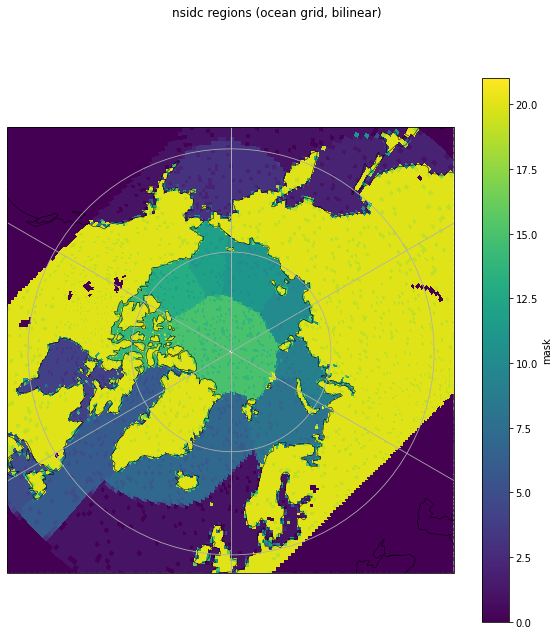

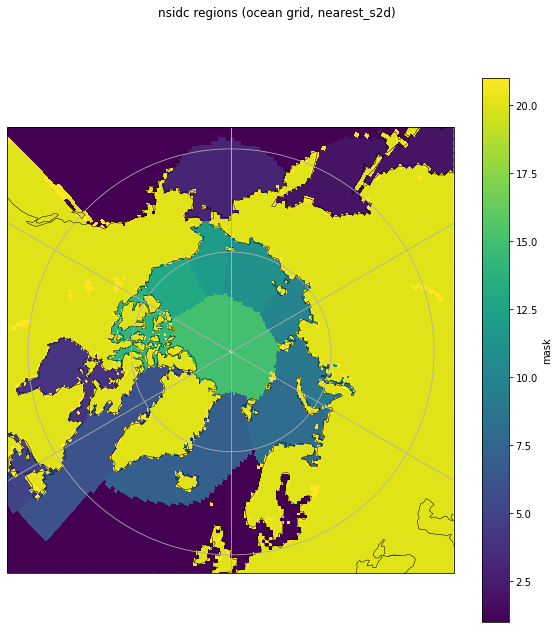

In [10]:
plot_regridded_data(
    nsidc_mask_regridded_o.mask, 
    title='nsidc regions (ocean grid, bilinear)', 
    x='longitude', 
    y='latitude'
)

plot_regridded_data(
    nsidc_mask_regridded_o_s2d.mask, 
    title='nsidc regions (ocean grid, nearest_s2d)', 
    x='longitude', 
    y='latitude'
)

## Precipitation (lat-lon) to sea-ice/ocean grid

In [11]:
pr_base = helpers.get_data('ssp585', 'Amon', 'pr', 'r2i1p1f2')

pr_regridded_o = regrid(pr_base, grid=siconc_base)
pr_regridded_o_ext = regrid(pr_base, grid=siconc_base, extrap_method='nearest_s2d')
pr_regridded_o_s2d = regrid(pr_base, grid=siconc_base, method='nearest_s2d')

pr_slice = pr_base.pr.where(pr_base.pr.lat > 60)[0, :, :]
pr_o_slice = pr_regridded_o.pr.where(pr_regridded_o.pr.latitude > 60)[0, :, :]
pr_o_ext_slice = pr_regridded_o_ext.pr.where(pr_regridded_o_ext.pr.latitude > 60)[0, :, :]
pr_o_s2d_slice = pr_regridded_o_s2d.pr.where(pr_regridded_o_s2d.pr.latitude > 60)[0, :, :]

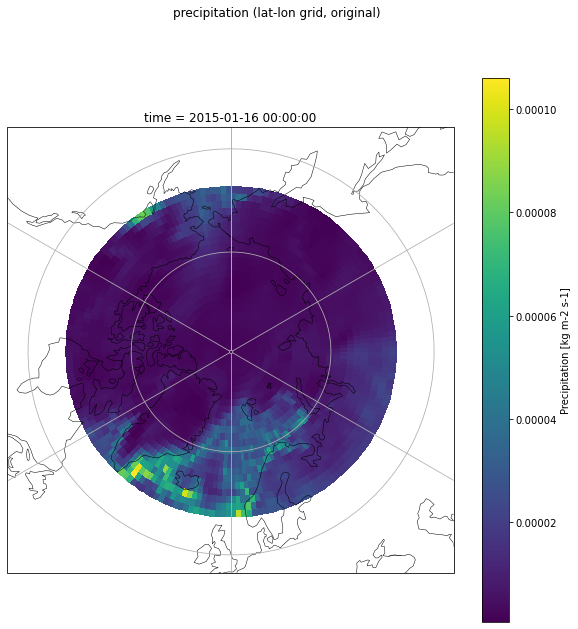

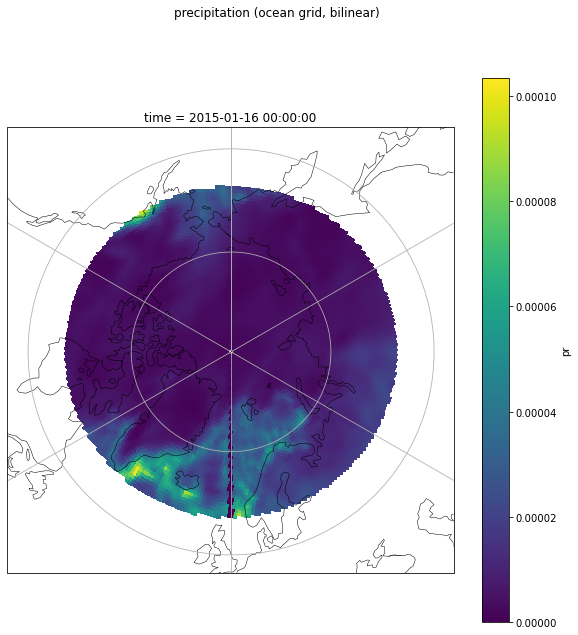

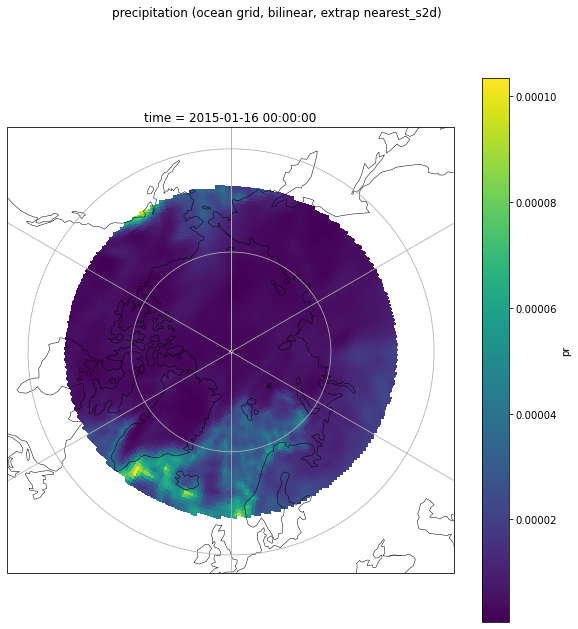

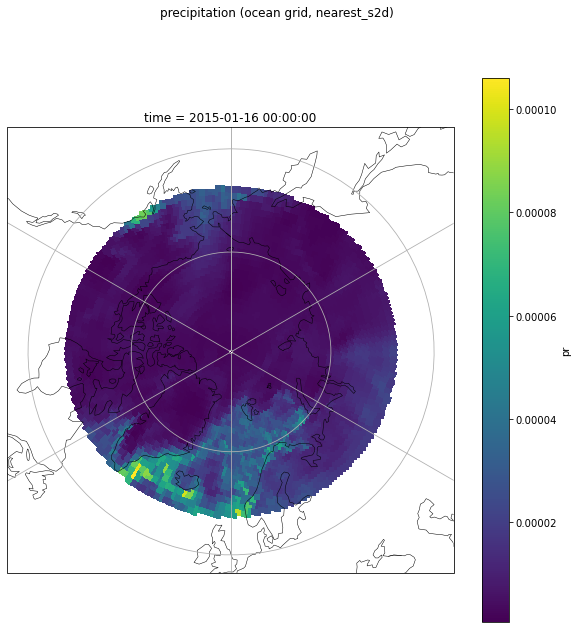

In [12]:
plot_regridded_data(
    pr_slice, 
    title='precipitation (lat-lon grid, original)', 
)

plot_regridded_data(
    pr_o_slice, 
    title='precipitation (ocean grid, bilinear)', 
    x='longitude', 
    y='latitude'
)

plot_regridded_data(
    pr_o_ext_slice, 
    title='precipitation (ocean grid, bilinear, extrap nearest_s2d)', 
    x='longitude', 
    y='latitude'
)

plot_regridded_data(
    pr_o_s2d_slice, 
    title='precipitation (ocean grid, nearest_s2d)', 
    x='longitude', 
    y='latitude'
)

In [13]:
nsidc_mask_latlon = xarray.open_mfdataset(paths=o_nearest_s2d, combine='by_coords')
nsidc_mask_latlon = nsidc_mask_latlon.mask.roll(x=96, roll_coords=True)

pr_slice = pr_slice.where(nsidc_mask_latlon.values == 7)
pr_o_slice = pr_o_slice.where(nsidc_mask_regridded_o_s2d.mask.values == 7)
pr_o_ext_slice = pr_o_ext_slice.where(nsidc_mask_regridded_o_s2d.mask.values == 7)
pr_o_s2d_slice = pr_o_s2d_slice.where(nsidc_mask_regridded_o_s2d.mask.values == 7)

pr_mean = pr_slice.weighted(areacella).mean(dim=('lat', 'lon'), skipna=True).values
pr_o_mean = pr_o_slice.weighted(areacello.fillna(0)).mean(dim=('i', 'j'), skipna=True).values
pr_o_ext_mean = pr_o_ext_slice.weighted(areacello.fillna(0)).mean(dim=('i', 'j'), skipna=True).values
pr_o_s2d_mean = pr_o_s2d_slice.weighted(areacello.fillna(0)).mean(dim=('i', 'j'), skipna=True).values

In [14]:
print('Precipitation over Greenland sea: weighted mean')
print(pr_mean, pr_o_mean, pr_o_ext_mean, pr_o_s2d_mean, sep='\n')

Precipitation over Greenland sea: weighted mean
3.4689518e-05
3.357143e-05
3.4388842e-05
3.4614142e-05


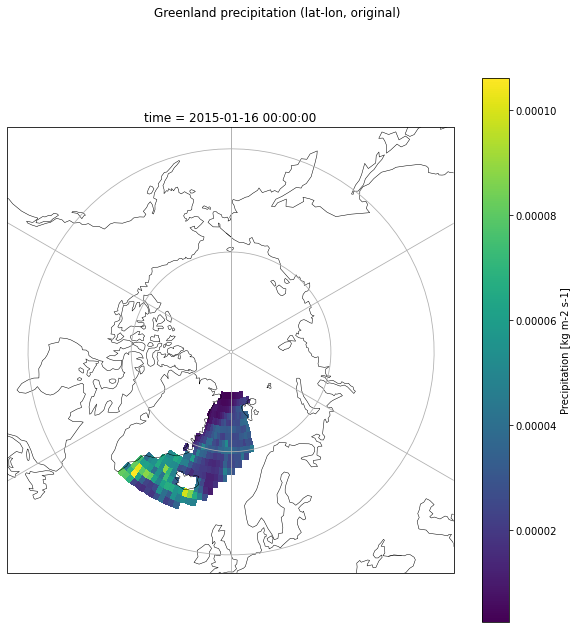

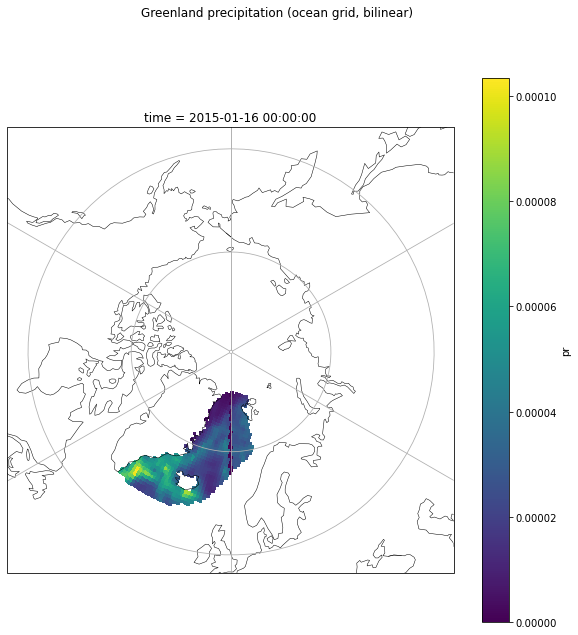

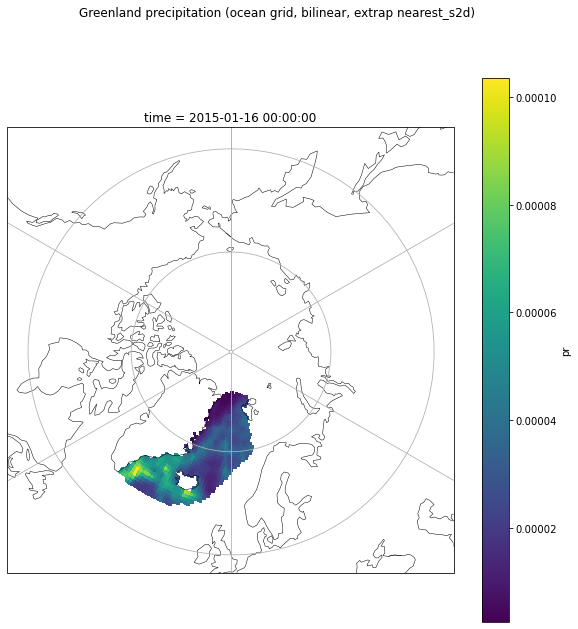

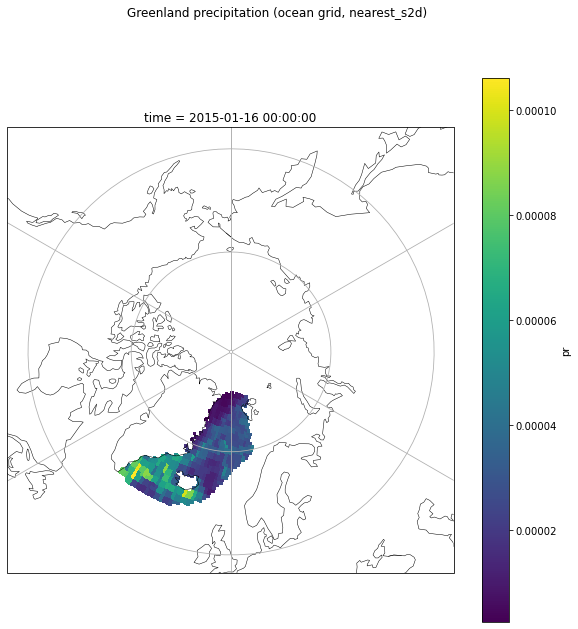

In [15]:
plot_regridded_data(
    pr_slice, 
    title='Greenland precipitation (lat-lon, original)', 
)
plot_regridded_data(
    pr_o_slice, 
    title='Greenland precipitation (ocean grid, bilinear)', 
    x='longitude', 
    y='latitude'
)

plot_regridded_data(
    pr_o_ext_slice, 
    title='Greenland precipitation (ocean grid, bilinear, extrap nearest_s2d)', 
    x='longitude', 
    y='latitude'
)

plot_regridded_data(
    pr_o_s2d_slice, 
    title='Greenland precipitation (ocean grid, nearest_s2d)', 
    x='longitude', 
    y='latitude'
)